## Packages import and data upload

In [1]:
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction import text
from sklearn.linear_model import LassoCV  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('assignment_dataset.csv')
df_2 = pd.read_csv('additional_wine_data.csv', encoding='latin-1')
df.head()

,title,variety,designation,country,province,description,price,winery,taster_name,points
0,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Vulkà Bianco,Italy,Sicily & Sardinia,"Aromas include tropical fruit, broom, brimston...",NaN,Nicosia,Kerin O’Keefe,87
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Avidagos,Portugal,Douro,"This is ripe and fruity, a wine that is smooth...",15.0,Quinta dos Avidagos,Roger Voss,87
2,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,NaN,US,Oregon,"Tart and snappy, the flavors of lime flesh and...",14.0,Rainstorm,Paul Gregutt,87
3,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,Reserve Late Harvest,US,Michigan,"Pineapple rind, lemon pith and orange blossom ...",13.0,St. Julian,Alexander Peartree,87
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Vintner's Reserve Wild Child Block,US,Oregon,"Much like the regular bottling from 2012, this...",65.0,Sweet Cheeks,Paul Gregutt,87


# <center>QUESTION 1</center>
### Some winemakers have asked you to buy their wines, which are new products not present in your list. How would you exploit the data you have to estimate the best price to buy them? 

## Preliminar alalysis on numerical fields

In [3]:
# the most part of the wines costs less than 100$ (=107808)
len(df[df['price'] >= 100])

3951

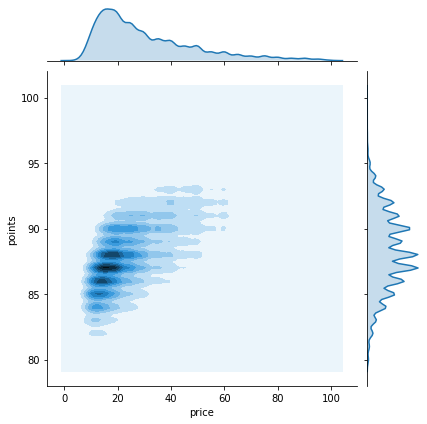

In [4]:
# first of all let's inspect the distribution of the two numerical field (restricted to the most common wines)
""" This distribution shows that there is not a clear relationship between price and points.
    The only thing that we can argue is that when the points are low (i.e. 80-83), then the 
    price distribution is more confined. """

sns.jointplot(x='price', y='points', data=df[['price', 'points']][df['price']<100], kind='kde')

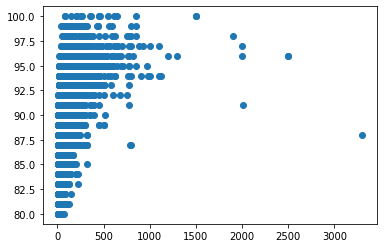

In [5]:
# the complete raw scatterplot shows this from another point of view
plt.scatter(df.price, df.points)

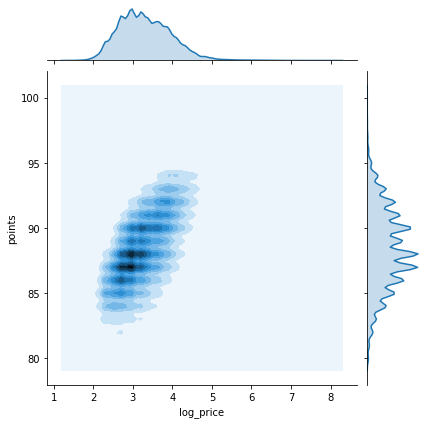

In [6]:
# let's log-transform the price variable and see what happen to the scatterplot
df['log_price'] = np.log(df.price)
sns.jointplot(x='log_price', y='points', data=df[['log_price', 'points']], kind='kde')

### The distribution looks more like a bivariate normal, so I'm gonna use the log-price as target field for the regression model.

## Data preprocessing

In [7]:
# -- Some cleaning --

# lowercase every string column
for col in df.columns:
    if (col != 'price') & (col != 'points') & (col != 'log_price'):
        df[col] = df[col].str.lower()

# drop duplicated rows (they would compromise the K-NN method)
df = df.drop_duplicates()

# drop rows where 'price' is NaN, since price is the target variable
df.dropna(subset=['price'], inplace=True)

In [8]:
# show unique values for every column
for col in df.columns:
    print('Column "{}" has {} distinct values.\n'.format(col, len(df[col].unique())))

Column "title" has 110630 distinct values.

Column "variety" has 698 distinct values.

Column "designation" has 35540 distinct values.

Column "country" has 43 distinct values.

Column "province" has 423 distinct values.

Column "description" has 111567 distinct values.

Column "price" has 390 distinct values.

Column "winery" has 15832 distinct values.

Column "taster_name" has 20 distinct values.

Column "points" has 21 distinct values.

Column "log_price" has 390 distinct values.



In [9]:
# feature selection 
""" title has too many distinct values. Also, title gives the same info of year, designation and winery combined.
    So I am going to use only year, country, province, taster_name, point and description cluster as 
    predictors for the regression model. Also, I add a column 'variety_type' by
    joining df with an additional dataframe df_2"""

# extract year from title
df['year'] = df.title.str.extract(r'(19\d{2}|2\d{3})')
# fill empty years with median value
df['year'] = df['year'].fillna(df['year'].median())
# round year to the closest decade
df['year'] = np.round(df['year'].astype(float)/10,0) * 10
df['year'] = df['year'].astype(int)

df_2 = df_2[['Varietal_Name', 'Varietal_WineType_Name']]
df_2['Varietal_Name'] = df_2['Varietal_Name'].str.lower()
df_2['Varietal_WineType_Name'] = df_2['Varietal_WineType_Name'].str.lower()
df_2 = df_2.drop_duplicates()

df_3 = pd.merge(df, df_2, how='left', left_on=['variety'], right_on=['Varietal_Name'])
df_3 = df_3.drop(['Varietal_Name'], axis=1)
df_3['Varietal_WineType_Name'] = df_3['Varietal_WineType_Name'].fillna('other')
df = df_3 

## NLP section
### Vectorization of the 'description' columns is implemented, after tokenization and stemming/lemmatization. The resulting numerical description is used to further implement a clustering for the comments.

In [10]:
# stemmer and lemming object
porter = PorterStemmer()
lancaster = LancasterStemmer()
lemm = WordNetLemmatizer()
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

In [11]:
# cleaning function
def cleanSentence(sentence):
    # tokenize
    token_words = word_tokenize(sentence)
    # remove punctuation and stop words
    filtered_sentence = [w for w in token_words if not w in stop_words]
    stem_sentence = []
    for word in filtered_sentence:
        # stemming
        word = lancaster.stem(word)
        # lemmatize
        word = lemm.lemmatize(word, pos='v')
        stem_sentence.append(word)
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [12]:
# apply the custom function to every row
df['description_new'] = df['description'].apply(lambda x: cleanSentence(x))

In [13]:
# vectorize the text with the TF-IDF approach
d = df['description_new'].values
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(d)
X.shape

(111593, 21601)

### Clustering of the comments

In [14]:
# ---------- !!!!!!!!!!!!!!!! ---------------------
# RUN THIS TO SKIP THE COMPUTATION OF THE NEXT CELL
distortions = pickle.load(open('distor.p', 'rb'))
K = range(1,14)

In [307]:
"""
# k-means elbow method for k selection (over-night computation)
# (based on sum of squared distances of samples to their closest cluster center)
distortions = []
K = range(1,14)
for k in K:
    km = KMeans(n_clusters = k)
    km.fit(X)
    distortions.append(km.inertia_)
"""

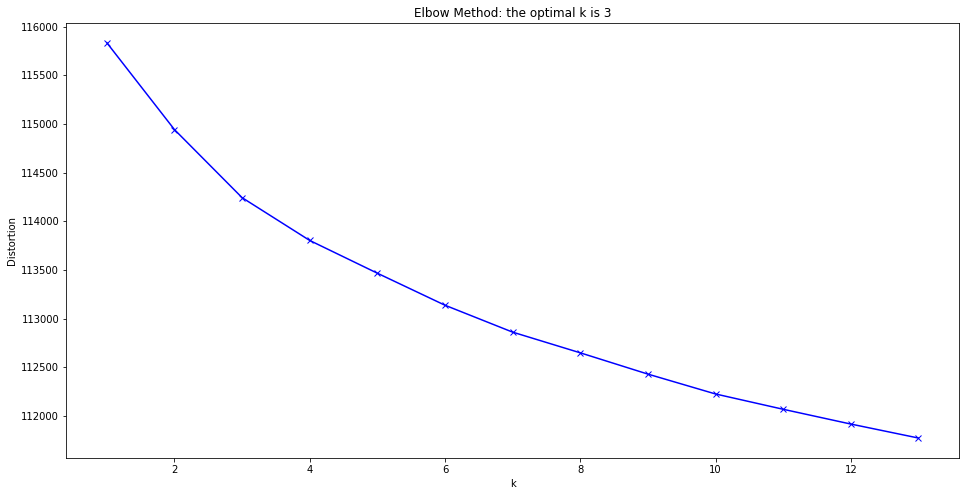

In [15]:
# plot k-means elbow method
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method: the optimal k is 3')
plt.show()

In [16]:
# ---------------- !!!!!!!!!!!!!!! ----------------
# RUN THIS TO SKIP THE COMPUTATION OF THE NEXT CELL
model_km = pickle.load(open('model_km.p', 'rb'))

In [15]:
"""
# best k = 3
best_k = 3
model_km = KMeans(n_clusters=best_k)
model_km.fit(X)
"""

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [17]:
# place every 'description' to its cluster
df['desc_cluster'] = model_km.labels_

## Regression model (Lasso model) 

In [18]:
# avoid the dummy variable trap (consider k-1 varibles)
regressors = pd.concat([pd.get_dummies(df.year, prefix='year').iloc[:,:-1],
                        df.points,
                        pd.get_dummies(df.variety, prefix='var').iloc[:,:-1],
                        pd.get_dummies(df.Varietal_WineType_Name, prefix='typvar').iloc[:,:-1],  
                        pd.get_dummies(df.country, prefix='country').iloc[:,:-1],
                        pd.get_dummies(df.province, prefix='prov').iloc[:,:-1],
                        pd.get_dummies(df.taster_name, prefix='taster').iloc[:,:-1],
                        pd.get_dummies(df.desc_cluster, prefix='clust').iloc[:,:-1]
                       ], axis = 1) 

In [19]:
# split dataset in training and test sets
X_train, X_test, y_train, y_test = train_test_split(regressors,   
                                                    df["log_price"],   
                                                    test_size=0.30, 
                                                    random_state=0)

In [20]:
# -------------- !!!!!!!!!!!!!!!! -----------------
# RUN THIS TO SKIP THE COMPUTATION OF THE NEXT CELL
lasso = pickle.load(open('model_lasso_cv.p', 'rb'))

In [406]:
"""
# Lasso linear model 
lasso = LassoCV(cv=10, precompute=True, normalize=True, n_jobs=-1).fit(X_train, y_train) 
"""

[Text(0.5, 0, 'Lasso Regression Coefficients')]

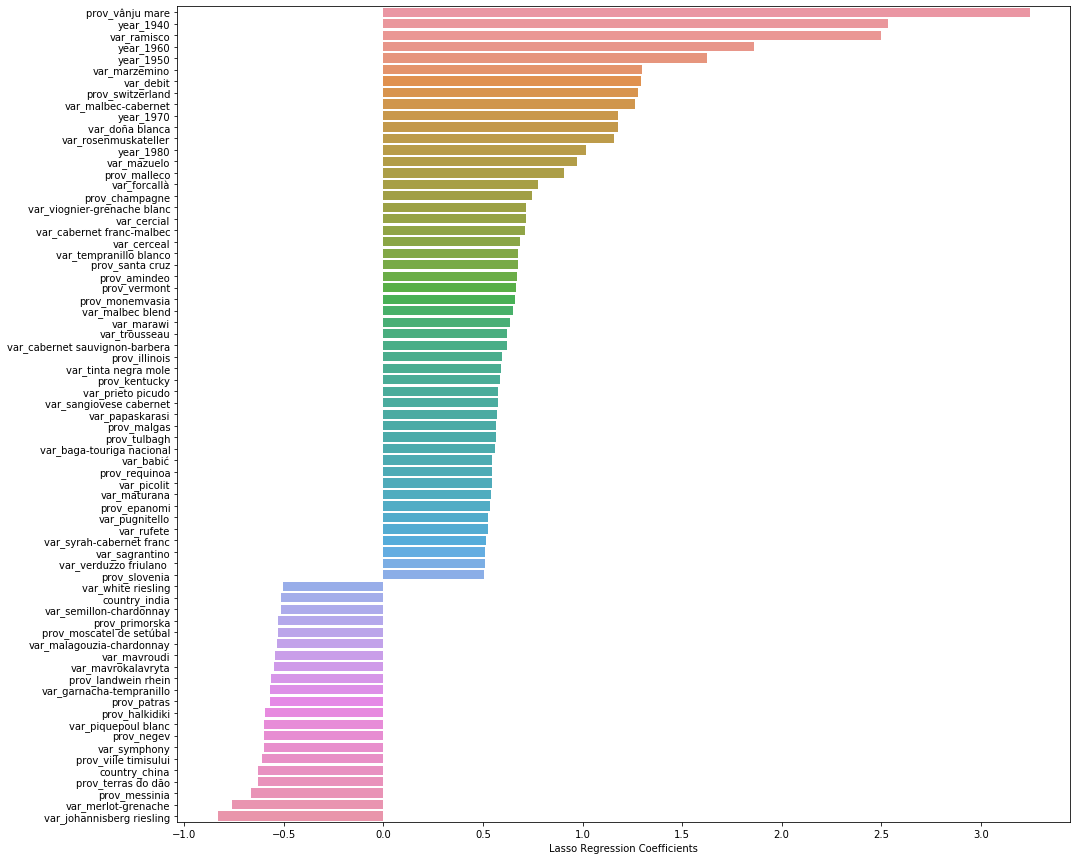

In [21]:
""" This barplot shows the largest coefficients of the fit in absolute value. Consistently with the common sense, 
    old wine should cost generally more, indeed some of these large positive coefficients
    are related to the decades 1940, 1950 and so on. On the contrary large negative coefficients are mostly
    related to regions not so popular for wine production. """

coef_df = pd.DataFrame(np.round_(lasso.coef_, decimals=3), 
                       regressors.columns, 
                       columns = ["lasso_coef"])  

# remove not-to-large coefficients for a better visualization
lasso_coef = coef_df[np.abs(coef_df['lasso_coef']) > 0.5]  
# sort the values from high to low  
lasso_coef = lasso_coef.sort_values(by='lasso_coef', ascending=False)  

# plot the sorted dataframe  
plt.figure(figsize=(16, 15))
ax = sns.barplot(x='lasso_coef', y=lasso_coef.index, data=lasso_coef)  
ax.set(xlabel='Lasso Regression Coefficients')  

### Model performance

In [22]:
# estimate error on training and test set (on log scale)
estim_te = lasso.predict(X_test)
estim_tr = lasso.predict(X_train)

e_vec_te = estim_te - y_test
e_te = np.dot(e_vec_te, e_vec_te) / len(e_vec_te)
print('Test MSE = {}\n'.format(np.round(e_te, 5)))

e_vec_tr = estim_tr - y_train
e_tr = np.dot(e_vec_tr, e_vec_tr) / len(e_vec_tr)
print('Train MSE = {}'.format(np.round(e_tr, 5)))

Test MSE = 0.19091

Train MSE = 0.18584


## Feedforward NN
### Trying to improve the previous performance of the Lasso Linear Regression model using a naive FNN with only one hidden layer and 100 ReLU hidden neurons

In [23]:
FNN = MLPRegressor()

In [24]:
# -------------- !!!!!!!!!!!!!!!! -----------------
# RUN THIS TO SKIP THE COMPUTATION OF THE NEXT CELL
FNN = pickle.load(open('fnn.p', 'rb'))

In [375]:
# FNN.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [25]:
# FNN performance
est_fnn_tr = FNN.predict(X_train)
est_fnn_te = FNN.predict(X_test)

e_v_fnn_te = est_fnn_te - y_test
e_fnn_te = np.dot(e_v_fnn_te, e_v_fnn_te) / len(e_v_fnn_te)
print('Test MSE = {}\n'.format(np.round(e_fnn_te, 5)))

e_v_fnn_tr = est_fnn_tr - y_train
e_fnn_tr = np.dot(e_v_fnn_tr, e_v_fnn_tr) / len(e_v_fnn_tr)
print('Train MSE = {}'.format(np.round(e_fnn_tr, 5)))

Test MSE = 0.17625

Train MSE = 0.16192


### This shows a relevant improvment with respect to the Lasso Linear Model. The big advantage of a NN approach is that such nets are able to model nonlinearities in the data, in this case using ReLU activations. This result can be definitely improved even more by using a deeper net and adjusting the hyperparameters with a validation set.
### -----------------------------------------------------------------------------------------------------------------------------

### From a web research I found out that the average gap between producer price and retail price is about 50%. This means that a wine bottle purchased at 33€ from a winemaker has a suggested retail price of 50€. 
### So, in order to estimate the best price to buy a not-listed new wine, one can use the predict method of the 'lasso2' object or the FNN object, which gives an estimation $x$ of the retail sell price. So a proper purchasing price could be $\frac{2}{3}x$.

# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------

# <center>QUESTION 2</center>
### Since you will have customers from different countries, you want to create a wine list that presents wines from different parts of the world. How could you identify which areas are similar for production? Select the best wines from such areas to create the best wine list.

In [ ]:
""" I opted to select 'variety', 'country' and 'province' as backbone of the selection process.
    This means that every possible combination (with some exceptions) of these 3 variables 
    will have at least one wine representant in the list. The adopted procedure to select the best 
    representants wines for any possible class is based on the points and price of the related wines. 
    This procedure will ensure that any possible region (again, with some exceptions) will have
    at least a representant, so any possible tourist/costumer can potentially find a bottle produced in his own
    native country, and hopefully also the variety he loves the most. 
    The list is created following these two criteria: 
    1) a high points/price ratio, 
    2) the price distribution should be uniform
    Point 2) ensure that a wealthy costumer can potentially find a proper 'not-so-cheap' bottle.
    
    There are about 4'000 classes and 111'000 samples. This means an average of 27 wines for any class.
    These 27 wines are in general not distinct, since multiple tasters can evaluate the same wine, 
    resulting in multiple points and descriptions. For this an aggreation will be performed in order
    to average the points of multiple tasters on the same title.
    
    If a class has not 'good' wines (e.g. there not exists an acceptable points/price ratio), 
    then no bottles will be associated to that class.
    
    Our winery will be awesome, our mission is to satisfy every possible customer,
    for this reason there will be a respectable number of bottles, let's say about 5000.
    """

In [26]:
# aggregate the points for a bottle of multiple tasters (fillna, otherwise some rows would be dropped)
df = df.fillna('unknown').groupby(['title', 'variety', 'designation', 'country', 'province',
                                   'price', 'winery'], as_index=False)\
       .agg({'points':'mean'})

### We ignore the 10% of all that bottle that have the lowest points/price ratio

Text(0, 0.95, '1.4')

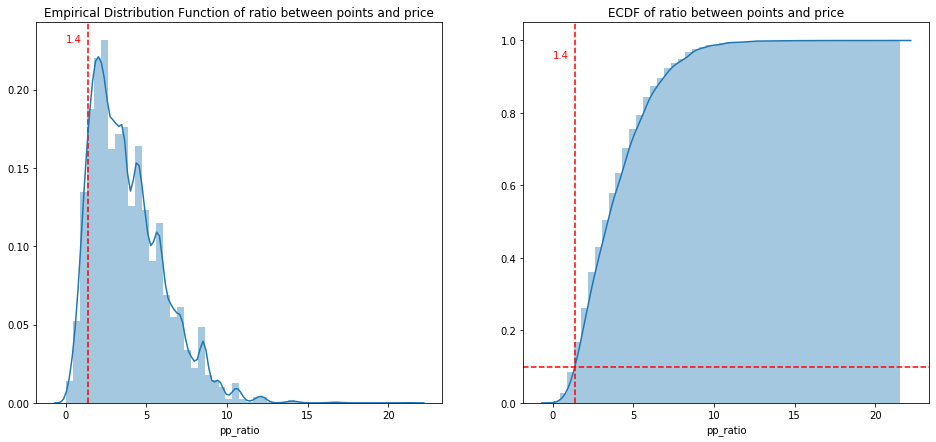

In [27]:
# estimate the average points/price ratio distribution
df['pp_ratio'] = df['points']/df['price']
perc = 10
p_value = np.percentile(df['pp_ratio'], q=perc)

kwargs = {'cumulative': True}
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.title('Empirical Distribution Function of ratio between points and price')
plt.axvline(p_value, c='r', linestyle='--')
sns.distplot(df['pp_ratio'])
plt.text(s=str(p_value), y=0.23, x=0, c='r')
plt.subplot(1,2,2)
plt.title('ECDF of ratio between points and price')
sns.distplot(df['pp_ratio'], hist_kws=kwargs, kde_kws=kwargs)
plt.axvline(p_value, c='r', linestyle='--')
plt.axhline(perc/100, c='r', linestyle='--')
plt.text(s=str(p_value), y=0.95, x=0, c='r')

In [28]:
# remove low pp_ratio
df_filt = df[df['pp_ratio'] > p_value]

In [29]:
# sort the dataframe in order to add a column which ranks the pp_ratio and the price and a column
# which count the numerosity of the class the bottle belongs to

df_filt['rank_ratio'] = df_filt.sort_values(by=['country','province', 'variety', 'pp_ratio', 'price'],
                                      ascending=[True, True, True, False, True])\
                               .groupby(['country','province', 'variety'])\
                               .cumcount() + 1

df_filt['rank_price'] = df_filt.sort_values(by=['country','province', 'variety', 'price', 'pp_ratio'],
                                      ascending=[True, True, True, False, True])\
                               .groupby(['country','province', 'variety'])\
                               .cumcount() + 1

df_agg = df_filt.groupby(['country','province', 'variety']).size().reset_index(name='counts')
df_agg['class'] = df_agg.index

# add counts column by left-joining
df_filt2 = pd.merge(df_filt, df_agg, how='left', on=['country','province', 'variety'])

In [30]:
df_filt2.sort_values(by=['country','province', 'variety', 'rank_ratio', 'rank_price'],
                                      ascending=[True, True, True, True, True]).head()

,title,variety,designation,country,province,price,winery,points,pp_ratio,rank_ratio,rank_price,counts,class
35885,espiritu de argentina 2008 bonarda (mendoza),bonarda,unknown,argentina,mendoza province,9.0,espiritu de argentina,87.0,9.666667,1,92,92,0
29092,dolce stefania 2007 bonarda (mendoza),bonarda,unknown,argentina,mendoza province,10.0,dolce stefania,90.0,9.000000,2,91,92,0
1987,alma del sur 2009 colección bonarda (mendoza),bonarda,colección,argentina,mendoza province,10.0,alma del sur,89.0,8.900000,3,89,92,0
2419,altos las hormigas 2009 colonia las liebres bo...,bonarda,colonia las liebres,argentina,mendoza province,10.0,altos las hormigas,89.0,8.900000,4,90,92,0
89829,tilia 2014 bonarda (mendoza),bonarda,unknown,argentina,mendoza province,10.0,tilia,88.0,8.800000,5,88,92,0


### Since we want a total of about 5'000 bottles, and df_filt2 contains about 100'000 wines, this means that we have to pick 5% of the grand total. This means that we have to select 5% of the count of the class, for every class, approximately. In order to avoid to obtain a list too big, a bottle will be chosen for the classes with less than 25 representants (4% of 25 is 1) only if the pp_ratio of some bottle is bigger than the 80th percentile.

In [31]:
perc2 = 80
p_val = np.percentile(df['pp_ratio'], q=perc2)
cols = ['title','variety','designation','country','province','price','winery','points']
big_list = pd.DataFrame(columns=cols)
for clas in df_filt2['class'].unique():
    df_tmp = df_filt2[df_filt2['class'] == clas]
    df_tmp.sort_values(by=['rank_price'], inplace=True)
    df_tmp.reset_index(drop=True, inplace=True)
    num = len(df_tmp)
    if num >= 25:
        # total number of bottles to select in this class
        n_bot = int(num / 25) + 1
        # add bottles with 'rank_ratio' == 1 for the large classes as first bottle
        idx = df_tmp[df_tmp['rank_ratio'] == 1].index[0]
        # create index list of all bottles, equally spaced in the price space
        idx_list = [(idx+25*i)%num for i in range(n_bot)]
        list_df = df_tmp.iloc[idx_list, :]
            
    else:
        # for the small classes pick only the rank1 bottle if the pp_ratio is above the 80th percentile
        list_df = df_tmp[(df_tmp['pp_ratio'] > p_val) & (df_tmp['rank_ratio'] == 1)]
        
    list_df = list_df[cols]
    big_list = pd.concat([big_list, list_df], axis=0)
big_list.reset_index(drop=True, inplace=True)

In [32]:
big_list.head()

,title,variety,designation,country,province,price,winery,points
0,raimat 2007 castell de raimat cabernet sauvign...,cabernet sauvignon,castell de raimat,spain,catalonia,10.0,raimat,82.0
1,la granja 360 nv brut sparkling (cava),sparkling blend,brut,spain,catalonia,7.0,la granja 360,84.0
2,maria casanovas 2014 brut nature gran reserva ...,sparkling blend,brut nature gran reserva,spain,catalonia,37.0,maria casanovas,90.0
3,llopart 2011 panoramic reserva imperial sparkl...,sparkling blend,panoramic reserva imperial,spain,catalonia,29.0,llopart,91.0
4,albet i noya 2013 brut natural reserva sparkli...,sparkling blend,brut natural reserva,spain,catalonia,25.0,albet i noya,90.0


In [33]:
big_list.shape

(5273, 8)